<h1><center>M3-M4 Long Quiz Part-B Mini Project - Bank Customer Churn Prediction</center></h1>

## Problem Statement

The objective is to develop a predictive model to identify customers who are likely to churn from the ABC bank. The bank has historical data on customer demographics, account information, credit score, product information etc.

<strong> Source for the dataset: </strong>https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset/

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from catboost import CatBoostClassifier, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
import timeit
from sklearn.metrics import classification_report, f1_score

### Reading the Dataset

In [2]:
df = pd.read_csv("./Dataset/Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Checking the stats of the dataset

In [4]:
# Check for outliers
col_stats_info = []
unique_cat_info = []

for col in df.columns:
    stats_dict = dict()
    cat_uniq_values_dict = dict()
    stats_dict['column_name'] = col
    stats_dict['samples_count'] = df[col].count()
    stats_dict['missing_val_count'] = df[col].isna().sum()
    if df[col].dtype != 'object':
        stats_dict['col_range'] = df[col].max() - df[col].min()
        stats_dict['max_value'] = df[col].max()
        stats_dict['min_value'] = df[col].min()
    else:
        stats_dict['col_range'] = np.nan
        stats_dict['modal_class'] = df[col].mode()[0]
        stats_dict['num_of_classes'] = df[col].nunique()
        cat_uniq_values_dict['column_name'] = col
        cat_uniq_values_dict['classes'] = df[col].unique()
    stats_dict['col_dtype'] = df[col].dtype

    col_stats_info.append(stats_dict)
    unique_cat_info.append(cat_uniq_values_dict)


stats_df = pd.DataFrame.from_dict(col_stats_info)
stats_df

,column_name,samples_count,missing_val_count,col_range,max_value,min_value,col_dtype,modal_class,num_of_classes
0,customer_id,10000,0,249989.00,15815690.00,15565701.00,int64,NaN,NaN
1,credit_score,10000,0,500.00,850.00,350.00,int64,NaN,NaN
2,country,10000,0,NaN,NaN,NaN,object,France,3.0
3,gender,10000,0,NaN,NaN,NaN,object,Male,2.0
4,age,10000,0,74.00,92.00,18.00,int64,NaN,NaN
5,tenure,10000,0,10.00,10.00,0.00,int64,NaN,NaN
6,balance,10000,0,250898.09,250898.09,0.00,float64,NaN,NaN
7,products_number,10000,0,3.00,4.00,1.00,int64,NaN,NaN
8,credit_card,10000,0,1.00,1.00,0.00,int64,NaN,NaN
9,active_member,10000,0,1.00,1.00,0.00,int64,NaN,NaN


In [5]:
feature_wise_unique_categories = pd.DataFrame.from_dict(unique_cat_info).dropna()
feature_wise_unique_categories

,column_name,classes
2,country,"[France, Spain, Germany]"
3,gender,"[Female, Male]"


### Identifying categorical and numerical columns

In [6]:
def categorize_columns(df, cat_threshold=10, car_threshold=30):
    
   
    categorical_cols = [col for col in df.columns if df[col].dtype == "O"]
    
    
    num_as_cat_cols = [col for col in df.columns if df[col].nunique() < cat_threshold and df[col].dtype != "O"]
    
    
    high_card_cat_cols = [col for col in df.columns if df[col].nunique() > car_threshold and df[col].dtype == "O"]
    
    categorical_cols = list(set(categorical_cols + num_as_cat_cols) - set(high_card_cat_cols))

   
    numerical_cols = [col for col in df.columns if df[col].dtype not in ["O", 'datetime64[ns]']]
    numerical_cols = list(set(numerical_cols) - set(num_as_cat_cols))

   
    binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

    print(f"Variables: {df.shape[1]}")
    print(f'Categorical columns: {len(categorical_cols)}')
    print(f'Numerical columns: {len(numerical_cols)}')
    print(f'High cardinality categorical columns: {len(high_card_cat_cols)}')
    print(f'Numerical columns with few unique values: {len(num_as_cat_cols)}')
    print(f'Binary columns: {len(binary_cols)}')

    return categorical_cols, numerical_cols, high_card_cat_cols, binary_cols

result = categorize_columns(df)
cat_cols, num_cols, bin_cols = result[0], result[1], result[3]

Variables: 12
Categorical columns: 6
Numerical columns: 6
High cardinality categorical columns: 0
Numerical columns with few unique values: 4
Binary columns: 4


In [7]:
print('Categorical columns: ', cat_cols)
print('Numeric columns: ', num_cols)
print('Binary columns: ', bin_cols)

Categorical columns:  ['churn', 'active_member', 'products_number', 'credit_card', 'country', 'gender']
Numeric columns:  ['tenure', 'estimated_salary', 'balance', 'customer_id', 'credit_score', 'age']
Binary columns:  ['gender', 'credit_card', 'active_member', 'churn']


### Distribution of categories for categorical columns

In [8]:
def cat_summary(dataframe, col_names):
    for col in col_names:
        print(pd.DataFrame({col: dataframe[col].value_counts(),
                            "% share": 100* dataframe[col].value_counts(normalize=True)}))
        print("##########################################")
cat_summary(df, cat_cols)

       churn  % share
churn                
0       7963    79.63
1       2037    20.37
##########################################
               active_member  % share
active_member                        
1                       5151    51.51
0                       4849    48.49
##########################################
                 products_number  % share
products_number                          
1                           5084    50.84
2                           4590    45.90
3                            266     2.66
4                             60     0.60
##########################################
             credit_card  % share
credit_card                      
1                   7055    70.55
0                   2945    29.45
##########################################
         country  % share
country                  
France      5014    50.14
Germany     2509    25.09
Spain       2477    24.77
##########################################
        gender  % share
gen

### Exploratory Data Analysis

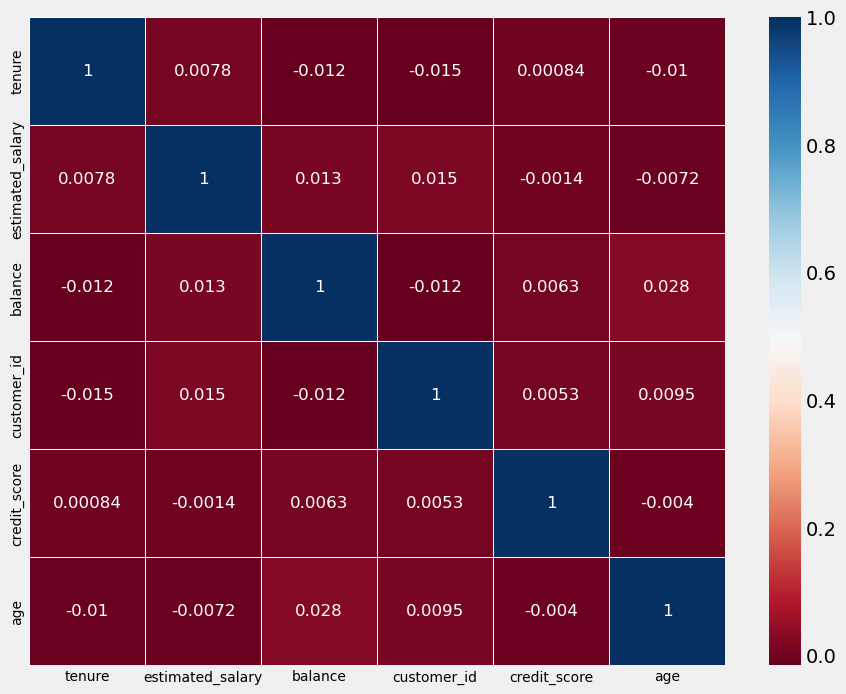

In [9]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

correlation_matrix(df, num_cols)

<Axes: ylabel='credit_score'>

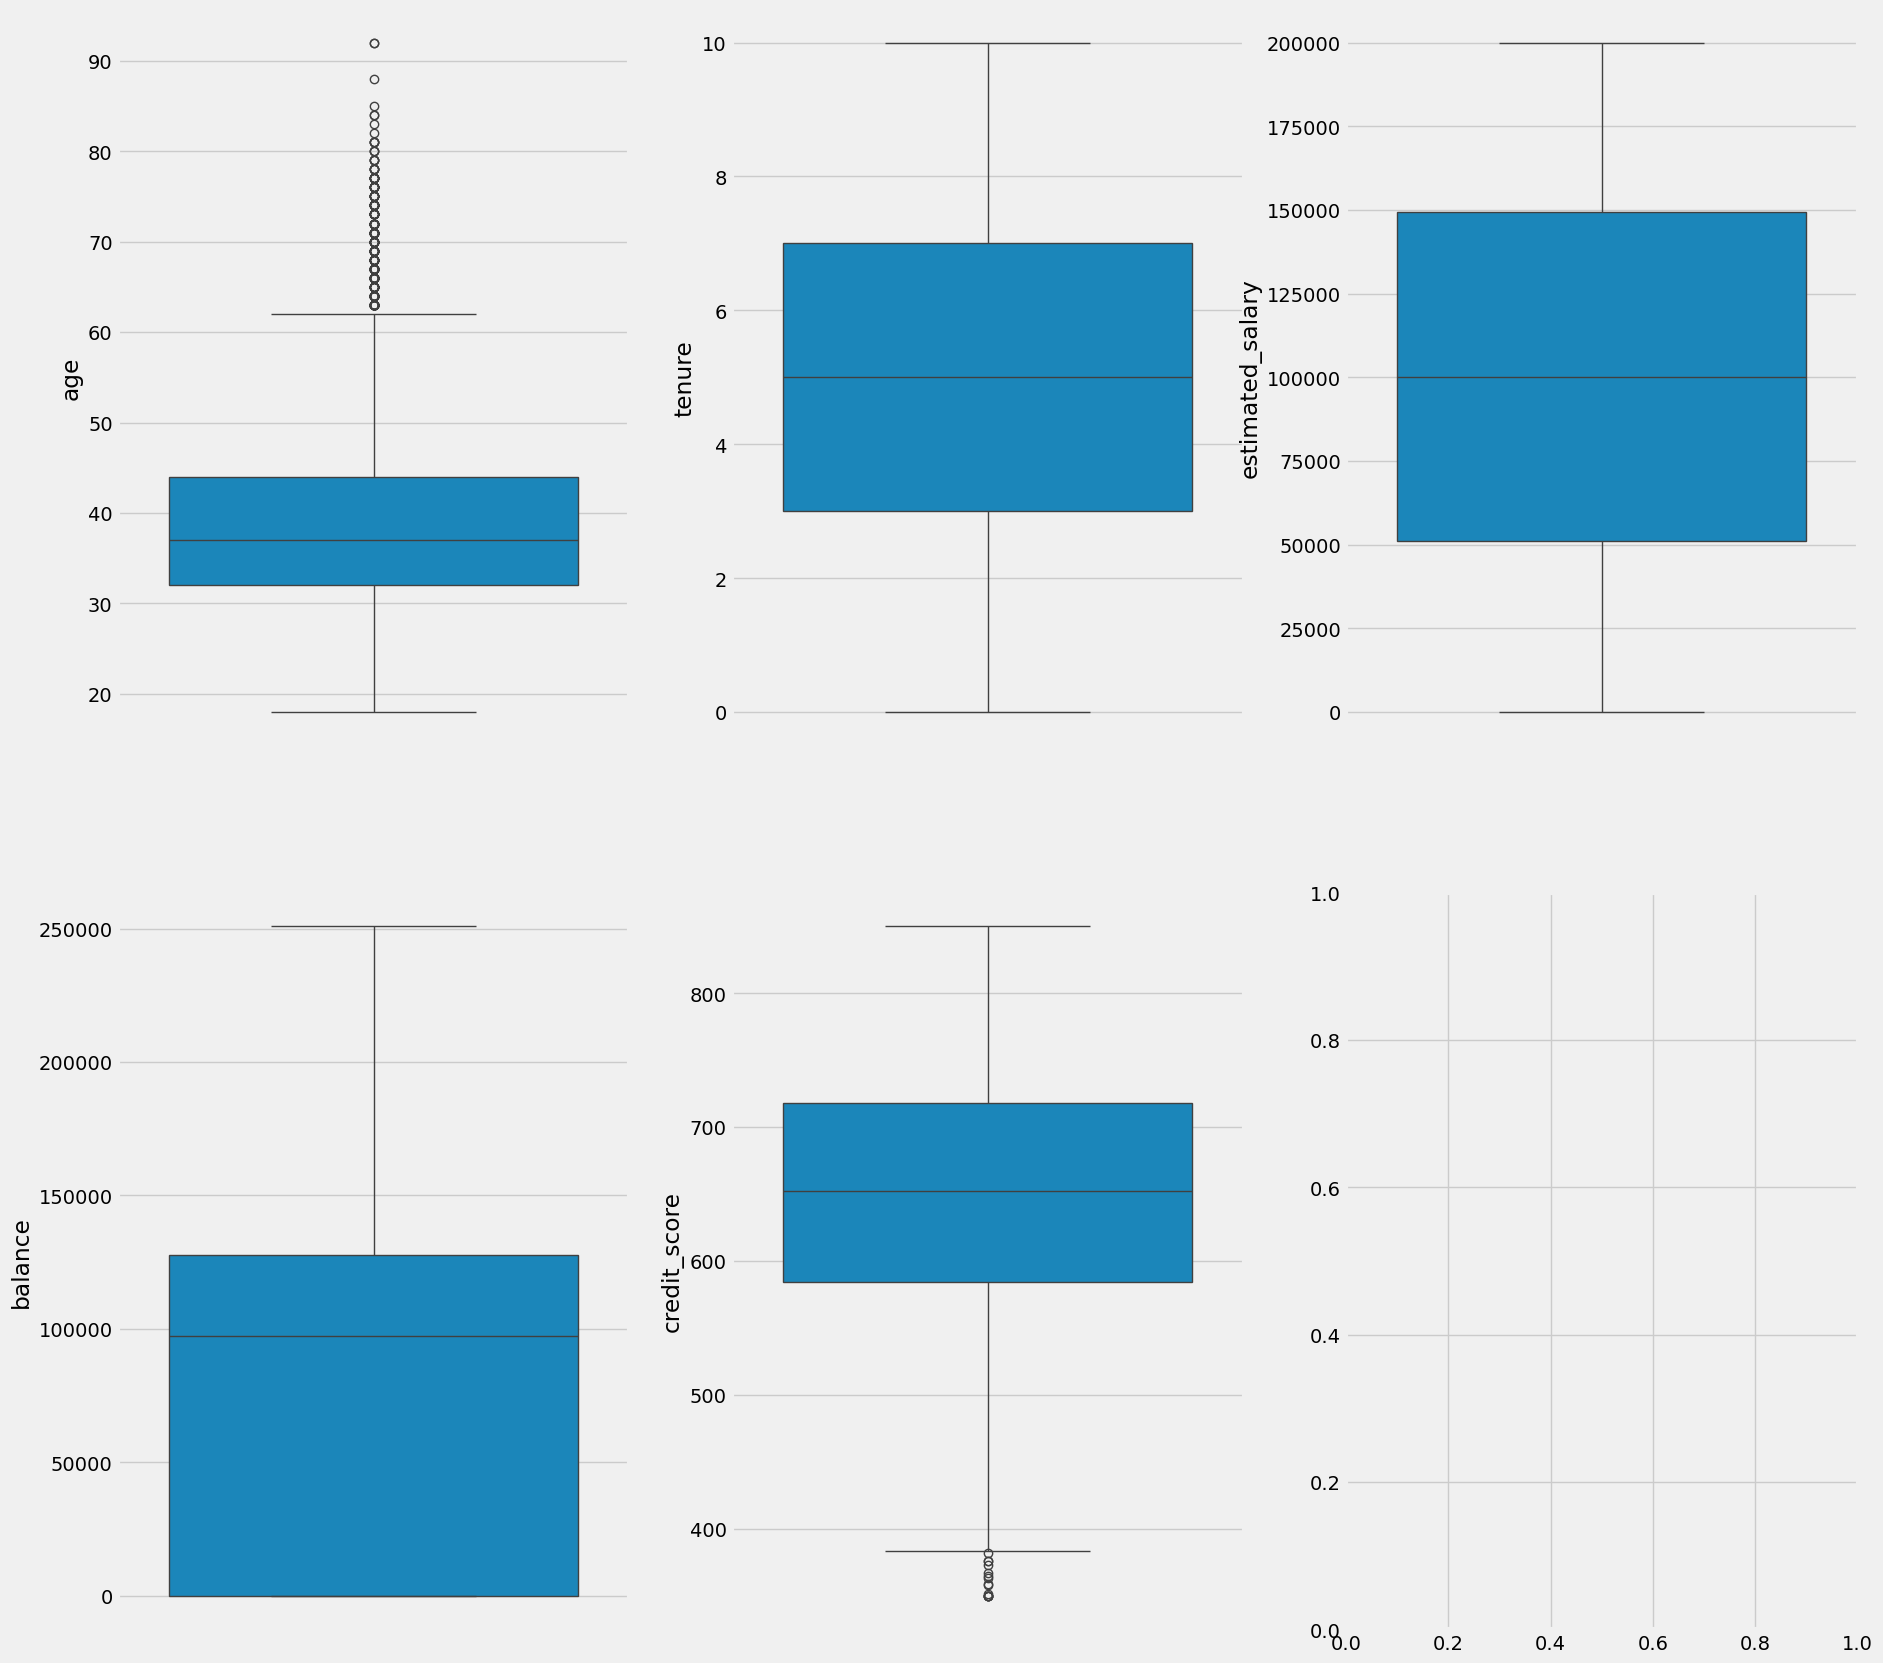

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
sns.boxplot(data=df['age'], ax=ax[0][0])
sns.boxplot(data=df['tenure'], ax=ax[0][1])
sns.boxplot(data=df['estimated_salary'], ax=ax[0][2])
sns.boxplot(data=df['balance'], ax=ax[1][0])
sns.boxplot(data=df['credit_score'], ax=ax[1][1])

<Axes: xlabel='active_member', ylabel='Count'>

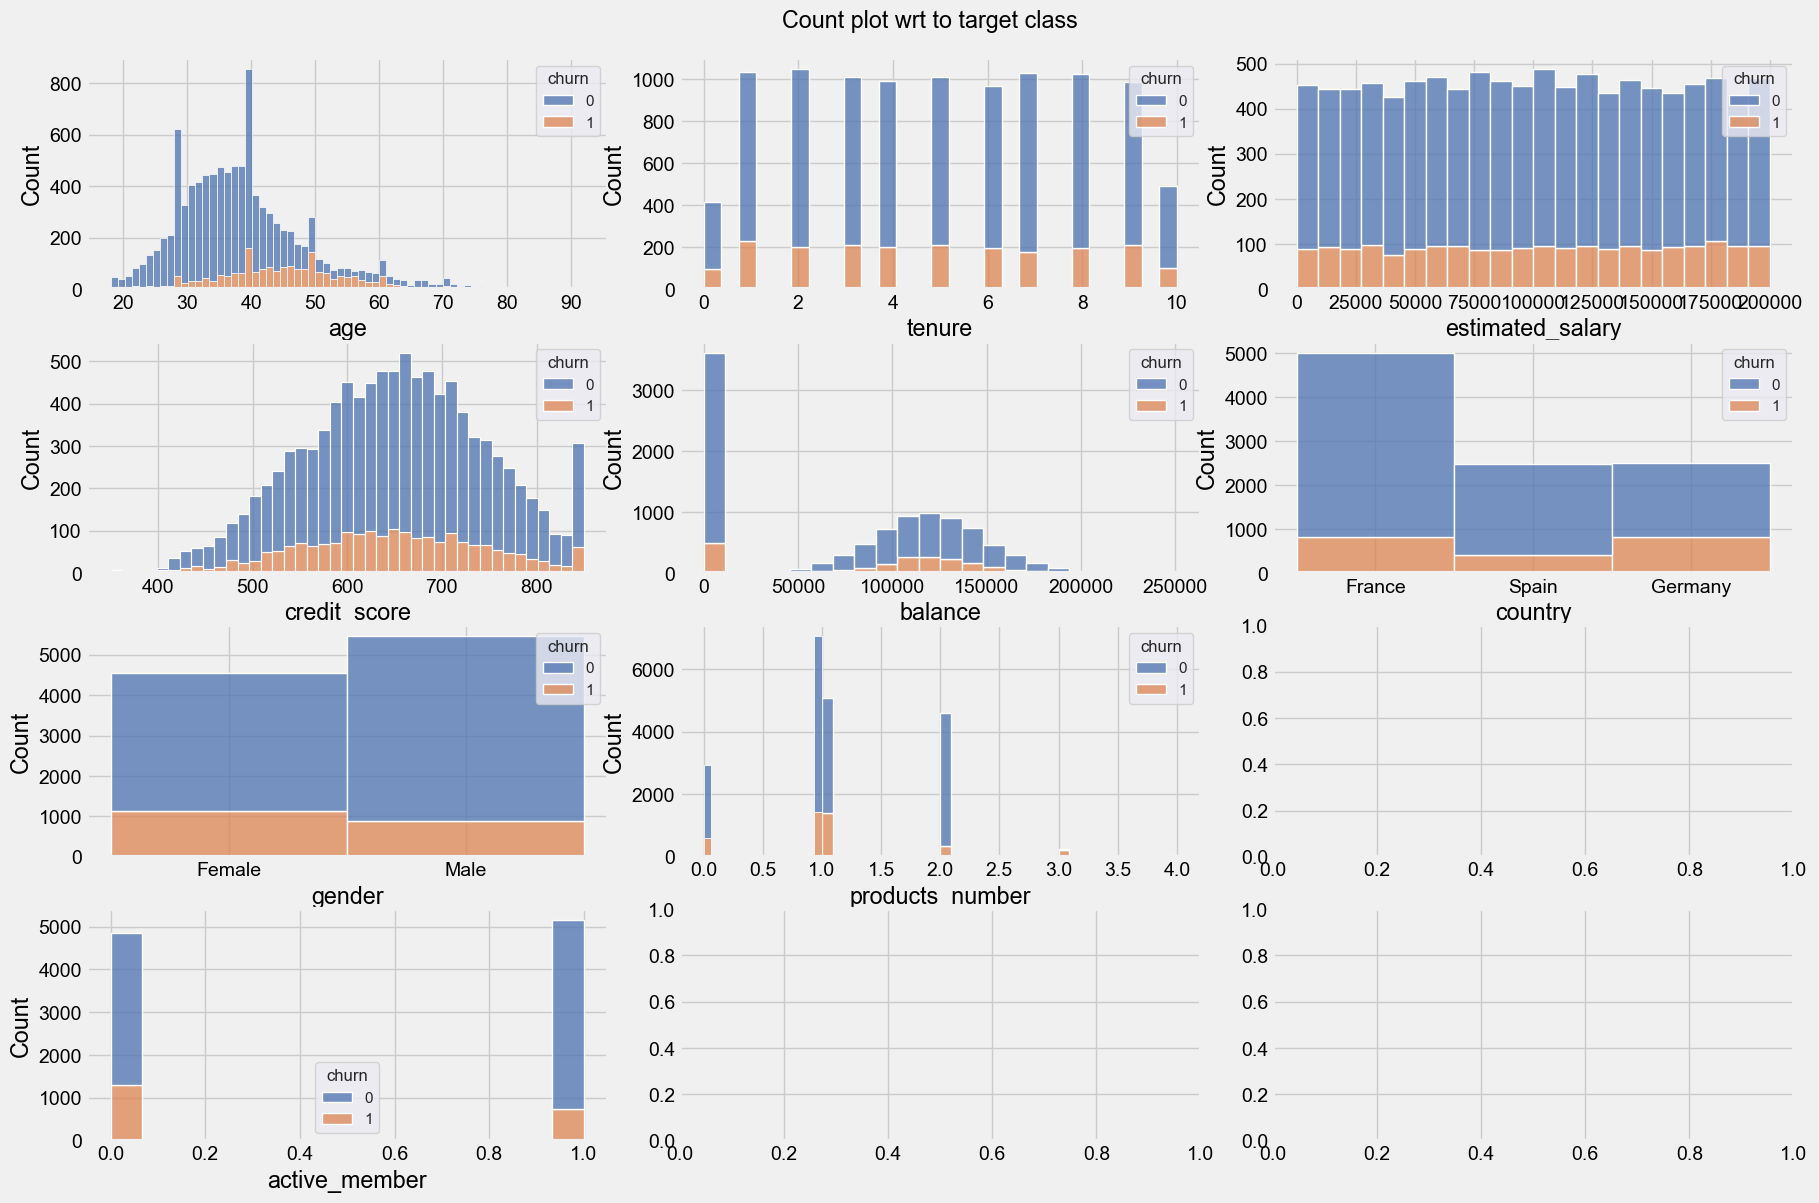

In [11]:
# Count plot
fig, axes = plt.subplots(4,3,figsize=(18,12))
fig.suptitle('Count plot wrt to target class')
fig.tight_layout()
sns.set()

sns.histplot(ax=axes[0, 0], data=df, x="age", hue="churn", multiple="stack")
sns.histplot(ax=axes[0, 1], data = df, x = 'tenure', hue = 'churn',multiple="stack")
sns.histplot(ax=axes[0, 2], data = df, x = 'estimated_salary', hue = 'churn',multiple="stack")

sns.histplot(ax=axes[1, 0], data = df, x = 'credit_score', hue = 'churn',multiple="stack")
sns.histplot(ax=axes[1, 1], data = df, x = 'balance', hue = 'churn',multiple="stack")
sns.histplot(ax=axes[1, 2], data = df, x = 'country', hue = 'churn',multiple="stack")

sns.histplot(ax=axes[2, 0], data = df, x = 'gender', hue = 'churn',multiple="stack")
sns.histplot(ax=axes[2, 1], data = df, x = 'products_number', hue = 'churn',multiple="stack")
sns.histplot(ax=axes[2, 1], data = df, x = 'credit_card', hue = 'churn',multiple="stack")

sns.histplot(ax=axes[3, 0], data = df, x = 'active_member', hue = 'churn',multiple="stack")

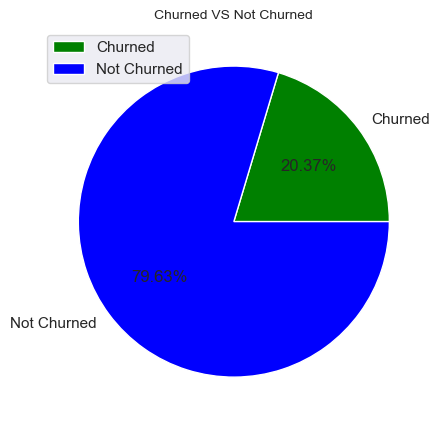

In [12]:
sizes = [df.churn[df['churn']==1].count(), df.churn[df['churn']==0].count()]
labels = ['Churned', 'Not Churned']
colors = ['green', 'blue']

plt.pie(sizes, labels=labels, autopct='%.2f%%', colors=colors)
plt.legend(loc='upper left')
plt.title("Churned VS Not Churned", size=10)
plt.show()

### Feature Engineering and Modularization

In [13]:
data = df.copy()
data.shape

(10000, 12)

In [14]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Dropping the customer ID column

In [15]:
class ColumnDropper(BaseEstimator, TransformerMixin):

    def __init__(self, col_list: list):

        if not isinstance(col_list, list):
            raise ValueError("Columns should be a list of strings")

        self.col_list = col_list

    def fit(self, dataframe = pd.DataFrame, target: pd.Series = None):

        return self

    def transform(self, dataframe = pd.DataFrame, target: pd.Series = None):

        df = dataframe.copy()
        df.drop(columns=self.col_list,inplace=True)

        return df

In [16]:
col_dropper = ColumnDropper(['customer_id'])

data = col_dropper.fit_transform(data)
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Binning the age variable

[17, 40, 60, 100]
No. of missing values: 0


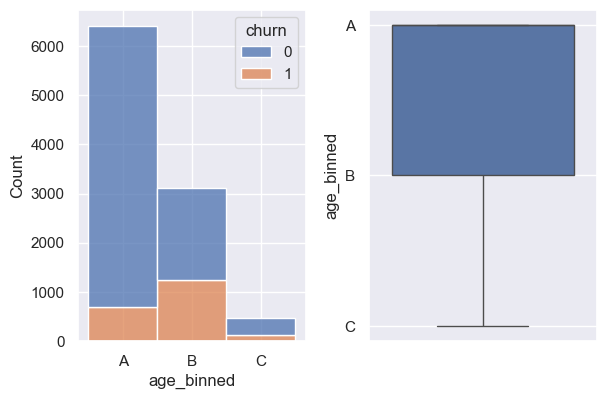

In [17]:
df1 = data.copy()
low_lm = df1['age'].min()
upp_lm = df1['age'].max()

bins = [17, 40, 60, 100]
print(bins)

df1['age_binned'] = pd.cut(df1['age'], bins, labels=['A', 'B', 'C'], include_lowest=True)

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
fig.tight_layout()
sns.set()

sns.histplot(ax=axes[0], data=df1, x="age_binned", hue="churn", multiple="stack")
sns.boxplot(ax=axes[1], data=df1['age_binned'])

print(f"No. of missing values: {len(df1[df1['age_binned'].isna()])}")

In [18]:
class Binner(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_list:list, bins:list, labels:list):

        if not isinstance(col_list, list):
            raise ValueError("Columns should be a list of strings")
            
        if not isinstance(bins, list):
            raise ValueError("Bins should be a list of integers")

        if not isinstance(labels, list):
            raise ValueError("Bins should be a list of strings")
        
        if bins is not None and labels is not None and len(bins) != len(labels) + 1:
            raise ValueError("Length of bins must be one more than the length of labels.")
            
        self.col_list = col_list
        self.bins = bins
        self.labels = labels        
    
    def fit(self, dataframe: pd.DataFrame, target: pd.Series = None):

        return self
    
    def transform(self, dataframe: pd.DataFrame):
        df =  dataframe.copy()
        
        for col in self.col_list:
            df[f"{col}_binned"] = pd.cut(df[col], bins=self.bins, labels=self.labels, right=False)
            
        return df

In [19]:
age_binner = Binner(['age'], [17, 40, 60, 100], ['A', 'B', 'C'])

data = age_binner.fit_transform(data)
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_binned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,B
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,B
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,B
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,A
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,B


#### Mapping the least frequent product number

<Axes: ylabel='products_number_upd'>

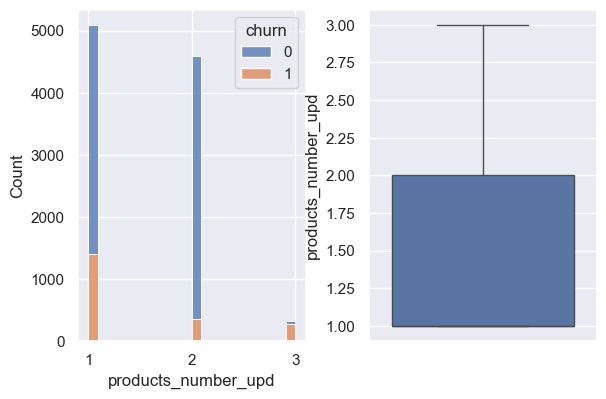

In [20]:
df1['products_number_upd'] = np.where(df1['products_number']==4, 3, df1['products_number'])

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
fig.tight_layout()
sns.set()

sns.histplot(ax=axes[0], data=df1, x="products_number_upd", hue="churn", multiple="stack")
sns.boxplot(ax=axes[1], data=df1['products_number_upd'])

In [21]:
class Mapper(BaseEstimator, TransformerMixin):
    """
    Ordinal categorical variable mapper:
    Treat column as Ordinal categorical variable, and assign values accordingly
    """

    def __init__(self, col_map: dict):

        if not isinstance(col_map, dict):
            raise ValueError("Mappings should be a dictionary of col, strings pair")
        self.col_map = col_map

    def fit(self, dataframe: pd.DataFrame, target: pd.Series = None):

        return self

    def transform(self, dataframe: pd.DataFrame):
        
        df = dataframe.copy()

        for key, val in self.col_map.items():
            df[key] = df[key].map(val)

        return df

In [22]:
mapping_dict = {
'products_number': {1:1, 2:2, 3:3, 4: 3},
}
clmapper = Mapper(mapping_dict)
data = clmapper.fit_transform(data)
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_binned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,B
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,B
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,B
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,A
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,B


In [23]:
data['products_number'].value_counts()

products_number
1    5084
2    4590
3     326
Name: count, dtype: int64

#### Handling the credit score outliers

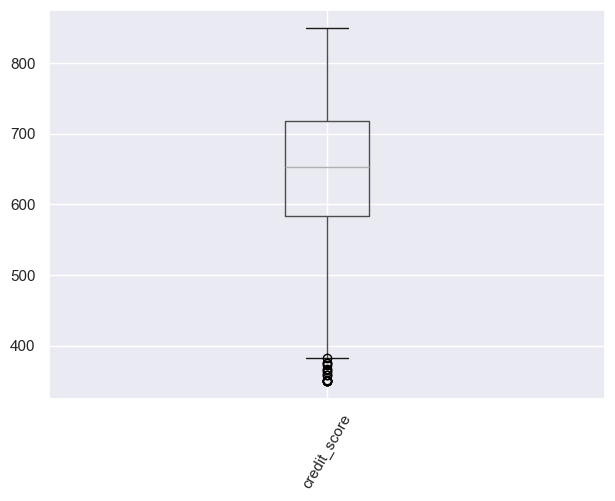

In [24]:
df1[['credit_score']].boxplot()
plt.xticks(rotation= 60)
plt.show()

In [25]:
def handle_outliers(dataframe, colm):

    df = dataframe.copy()
    q1 = df.describe()[colm].loc['25%']
    q3 = df.describe()[colm].loc['75%']
    iqr = q3 - q1
    lower_bound = int(q1 - (1.5 * iqr))
    upper_bound = int(q3 + (1.5 * iqr))
    for i in df.index:
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound

    return df

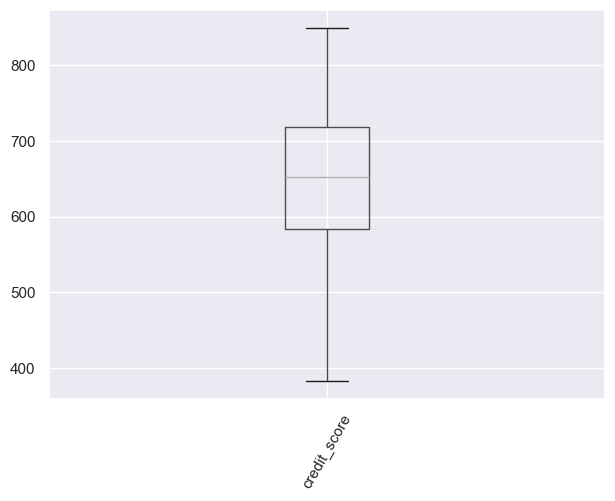

In [26]:
df1 = handle_outliers(df1, 'credit_score')

df1[['credit_score']].boxplot()
plt.xticks(rotation= 60)
plt.show()

In [27]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Change the outlier values:
        - to upper-bound, if the value is higher than upper-bound, or
        - to lower-bound, if the value is lower than lower-bound respectively.
    """

    def __init__(self, col_list: list):

        if not isinstance(col_list, list):
            raise ValueError("Columns should be a list of strings")
        self.col_list = col_list
        self.limit_dict = {}

    def fit(self, dataframe: pd.DataFrame, target: pd.Series = None):

        df = dataframe.copy()

        for col in self.col_list:

            q1 = df.describe()[col].loc['25%']
            q3 = df.describe()[col].loc['75%']
            iqr = q3 - q1
            lower_bound = int(q1 - (1.5 * iqr))
            upper_bound = int(q3 + (1.5 * iqr))
            self.limit_dict[col] = [lower_bound, upper_bound]

        self.limits = self.limit_dict
        return self


    def transform(self, dataframe: pd.DataFrame):
        
        df = dataframe.copy()

        for col in self.col_list:
            for i in df.index:

                if df.loc[i,col] > self.limits[col][1]:
                    df.loc[i,col]= self.limits[col][1]

                if df.loc[i,col] < self.limits[col][0]:
                    df.loc[i,col]= self.limits[col][0]

        return df

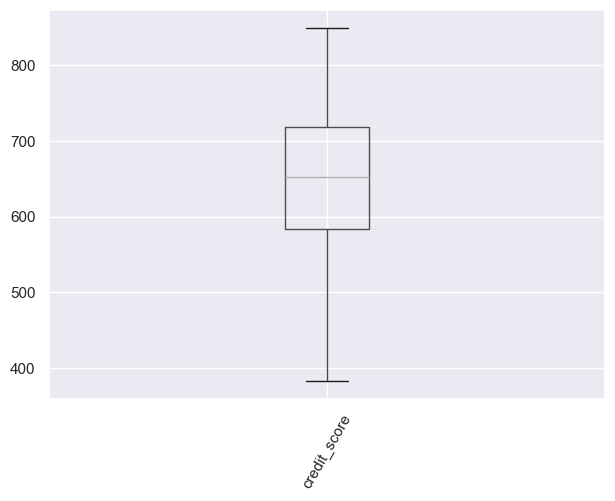

In [28]:
outtreat = OutlierHandler(['credit_score'])
data = outtreat.fit_transform(data)

data[['credit_score']].boxplot()
plt.xticks(rotation= 60)
plt.show()

#### Binning the Balance variable

In [29]:
# Instantiating Binner class with different bin edges and labels for binning

bal_binner = Binner(['balance'], [-1,50000, 100000, 150000, 200000, np.inf], ['A', 'B', 'C', 'D','E'])

data = bal_binner.fit_transform(data)
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_binned,balance_binned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,B,A
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,B,B
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,B,D
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,A,A
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,B,C


<Axes: ylabel='balance_binned'>

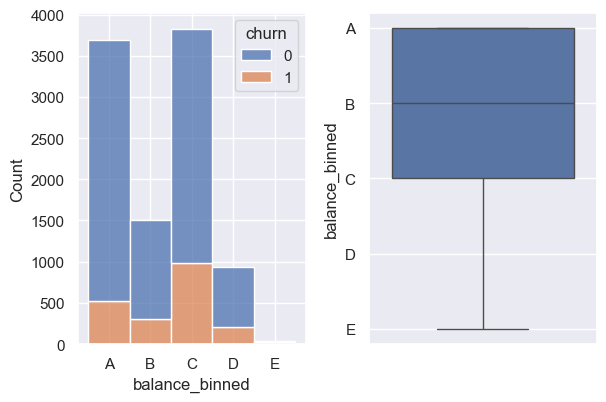

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
fig.tight_layout()
sns.set()

sns.histplot(ax=axes[0], data=data, x="balance_binned", hue="churn", multiple="stack")
sns.boxplot(ax=axes[1], data=data['balance_binned'])

#### Binning the Tenure variable

In [31]:
# Instantiating Binner class with different bin edges and labels for binning

tenure_binner = Binner(['tenure'], [-1, 2, 4, 6, 8, np.inf], ['A', 'B', 'C', 'D', 'E'])

data = tenure_binner.fit_transform(data)
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_binned,balance_binned,tenure_binned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,B,A,B
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,B,B,A
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,B,D,E
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,A,A,A
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,B,C,B


<Axes: ylabel='tenure_binned'>

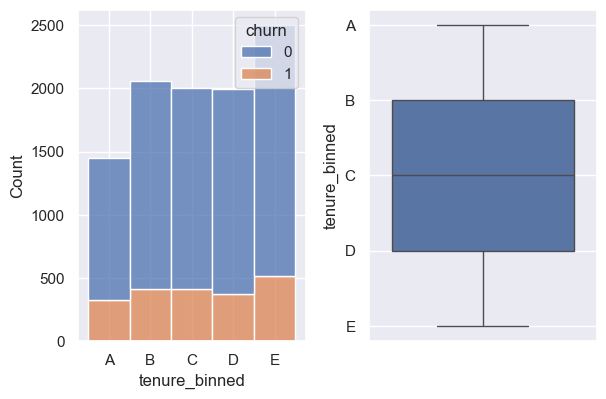

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
fig.tight_layout()
sns.set()

sns.histplot(ax=axes[0], data=data, x="tenure_binned", hue="churn", multiple="stack")
sns.boxplot(ax=axes[1], data=data['tenure_binned'])

#### One Hot Encoding the categorical columns country and gender

In [33]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop=None)
col_list = ['country', 'gender']

one_hot_encoded = encoder.fit_transform(df1[col_list])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_list))
df1 = pd.concat([df1, one_hot_df], axis=1)
df1 = df1.drop(col_list, axis=1)

In [34]:
df1.head(2)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_binned,products_number_upd,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,B,1,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,B,1,0.0,0.0,1.0,1.0,0.0


In [35]:
class ColOneHotEncoder(BaseEstimator, TransformerMixin):
    """ One-hot encode a column """

    def __init__(self, col_list: list):

        if not isinstance(col_list, list):
            raise ValueError("Columns should be a list of strings")

        self.col_list = col_list
        self.categories_ = {}

    def fit(self, dataframe: pd.DataFrame, target: pd.Series = None):

        df = dataframe.copy()
        for col in self.col_list:
            self.categories_[col] = df[col].unique()
            self.categories_[col] = [col for col in self.categories_[col] if str(col) != 'nan']

        return self

    def transform(self, dataframe: pd.DataFrame):
        
        if not self.categories_:
            raise ValueError("Must fit the transformer before transforming the data.")

        df = dataframe.copy()
        for col in self.col_list:
            categories = self.categories_[col]
            for category in categories:
                new_column_name = f"{col}_{category}"
                df[new_column_name] = (df[col] == category).astype(int)
            df = df.drop(col, axis=1)

        return df

In [36]:
onehot = ColOneHotEncoder(col_list)

data = onehot.fit_transform(data)

data.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_binned,balance_binned,tenure_binned,country_France,country_Spain,country_Germany,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,B,A,B,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,B,B,A,0,1,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,B,D,E,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,A,A,A,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,B,C,B,0,1,0,1,0


#### Label encoding the categorical features

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   age               10000 non-null  int64   
 2   tenure            10000 non-null  int64   
 3   balance           10000 non-null  float64 
 4   products_number   10000 non-null  int64   
 5   credit_card       10000 non-null  int64   
 6   active_member     10000 non-null  int64   
 7   estimated_salary  10000 non-null  float64 
 8   churn             10000 non-null  int64   
 9   age_binned        10000 non-null  category
 10  balance_binned    10000 non-null  category
 11  tenure_binned     10000 non-null  category
 12  country_France    10000 non-null  int32   
 13  country_Spain     10000 non-null  int32   
 14  country_Germany   10000 non-null  int32   
 15  gender_Female     10000 non-null  int32   
 16  gender_Male       10000

In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in ['age_binned', 'balance_binned', 'tenure_binned']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le
    
data.head(2)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_binned,balance_binned,tenure_binned,country_France,country_Spain,country_Germany,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,1,0,0,1,0,1,0


In [39]:
class ColLabelEncoder(BaseEstimator, TransformerMixin):
    """ One-hot encode a column """

    def __init__(self, col_list: list):

        if not isinstance(col_list, list):
            raise ValueError("Columns should be a list of strings")

        self.col_list = col_list
        self.encoders = {}

    def fit(self, dataframe: pd.DataFrame, target: pd.Series = None):

        df = dataframe.copy()
        for column in self.col_list:
            
            le = LabelEncoder()
            le.fit(df[column])
            self.encoders[column] = le
            
        return self

    def transform(self, dataframe: pd.DataFrame):
        
        if not self.encoders:
            raise ValueError("Must fit the transformer before transforming the data.")

        df = dataframe.copy()

        for column, le in self.encoders.items():
            df[column] = le.transform(df[column])
            
        return df

### Model training

In [40]:
target = data['churn']
target.shape

(10000,)

In [41]:
features = data.drop(['churn'], axis=1)
features.shape

(10000, 16)

In [42]:
# Splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2, stratify=target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 16), (2000, 16), (8000,), (2000,))

#### Scaling the input features

In [43]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled[0,:]

X_test_scaled = scaler.transform(X_test)
X_test_scaled[0,:]

array([-0.68173886, -0.27993196,  0.68472287, -1.22605881,  0.85119078,
        0.64104192, -1.030206  , -0.09502138, -0.76224348, -1.14815885,
        0.56941661,  1.00175153, -0.57773517, -0.57831252, -0.90750738,
        0.90750738])

#### CatBoost Model

In [44]:
# Initialize the CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,            # Number of trees
    depth=7,                    # Depth of each tree
    learning_rate=0.05,        # Learning rate
    loss_function='Logloss',    
    auto_class_weights='Balanced',
    verbose=100,                # Print log information every 100 iterations
    random_state=42
)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print(f"AUC score: {roc_auc_score(y_test, y_pred): .2f}")
print(f"F1-score: {f1_score(y_test, y_pred):.2f}")

0:	learn: 0.6716868	total: 137ms	remaining: 1m 8s
100:	learn: 0.4001344	total: 496ms	remaining: 1.96s
200:	learn: 0.3528172	total: 865ms	remaining: 1.29s
300:	learn: 0.3076687	total: 1.23s	remaining: 810ms
400:	learn: 0.2723081	total: 1.61s	remaining: 397ms
499:	learn: 0.2437119	total: 1.98s	remaining: 0us
Accuracy(in %): 82.39999999999999
AUC score:  0.77
F1-score: 0.61


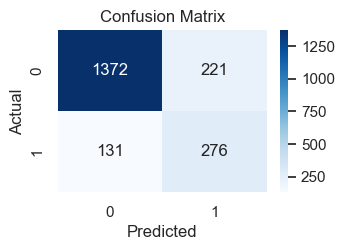

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      1593
           1       0.56      0.68      0.61       407

    accuracy                           0.82      2000
   macro avg       0.73      0.77      0.75      2000
weighted avg       0.84      0.82      0.83      2000



In [45]:
# Plot the confusion matrix as a heatmap

confusion = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(3, 2))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

#### Plotting Feature importances

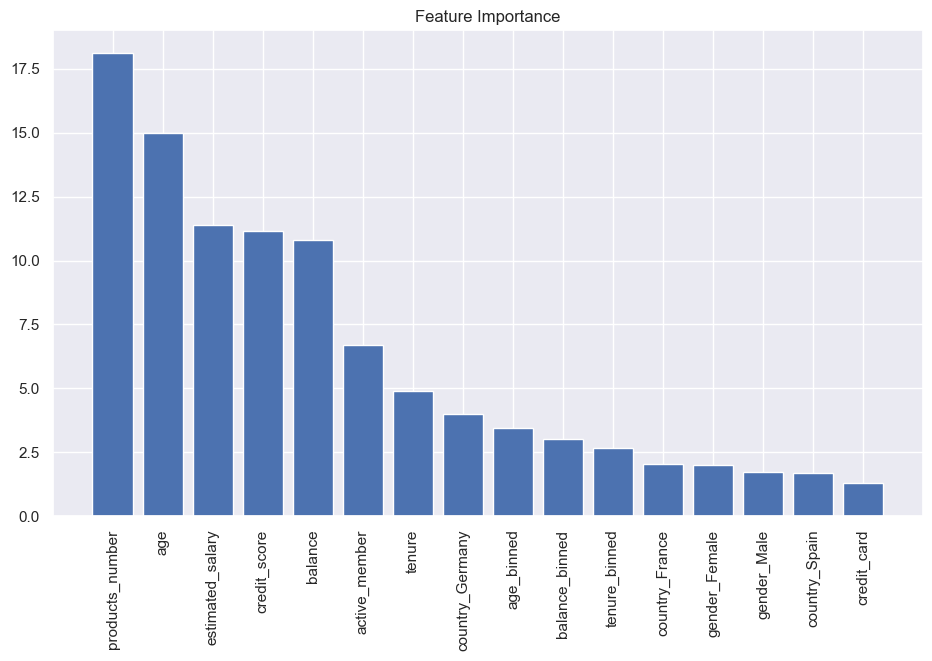

In [46]:
importances = model.get_feature_importance()
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), importances[sorted_indices])
plt.xticks(range(len(feature_names)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.show()

#### Cross validation using sklearn cross_validate

In [47]:
cv_results = cross_validate(model, X_train_scaled, y_train, cv=3, scoring=["accuracy", "f1", "roc_auc"])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()
print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

0:	learn: 0.6705505	total: 3.28ms	remaining: 1.64s
100:	learn: 0.3822117	total: 343ms	remaining: 1.35s
200:	learn: 0.3165048	total: 669ms	remaining: 995ms
300:	learn: 0.2653820	total: 1s	remaining: 662ms
400:	learn: 0.2247773	total: 1.35s	remaining: 333ms
499:	learn: 0.1931892	total: 1.7s	remaining: 0us
0:	learn: 0.6709533	total: 3.5ms	remaining: 1.75s
100:	learn: 0.3844236	total: 338ms	remaining: 1.33s
200:	learn: 0.3194864	total: 663ms	remaining: 986ms
300:	learn: 0.2695610	total: 1.02s	remaining: 672ms
400:	learn: 0.2299545	total: 1.39s	remaining: 342ms
499:	learn: 0.1982928	total: 1.75s	remaining: 0us
0:	learn: 0.6720495	total: 3.68ms	remaining: 1.84s
100:	learn: 0.3953856	total: 331ms	remaining: 1.31s
200:	learn: 0.3313057	total: 679ms	remaining: 1.01s
300:	learn: 0.2735384	total: 1.03s	remaining: 683ms
400:	learn: 0.2328093	total: 1.38s	remaining: 341ms
499:	learn: 0.1990972	total: 1.72s	remaining: 0us
f1: 0.63
auc: 0.86
accuracy: 0.84


#### Grid Search

In [48]:
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=["accuracy", "f1", "roc_auc"],
    refit="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best model and print details
best_model = grid_search.best_estimator_
print(f"Best F1 score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 0.6716868	total: 4.2ms	remaining: 2.09s
100:	learn: 0.4001344	total: 385ms	remaining: 1.52s
200:	learn: 0.3528172	total: 761ms	remaining: 1.13s
300:	learn: 0.3076687	total: 1.15s	remaining: 759ms
400:	learn: 0.2723081	total: 1.53s	remaining: 379ms
499:	learn: 0.2437119	total: 1.92s	remaining: 0us
Best F1 score: 0.6260335356270986
Best parameters: {'iterations': 500, 'learning_rate': 0.05}


### Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 150, max_depth = 5,random_state = 42)

model_rf.fit(X_train_scaled, y_train)

y_pred = model_rf.predict(X_test_scaled)

print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print(f"AUC score: {roc_auc_score(y_test, y_pred): .2f}")
print(f"F1-score: {f1_score(y_test, y_pred):.2f}")

Accuracy(in %): 85.65
AUC score:  0.67
F1-score: 0.50


Since the CatBoost model gives better F1 score, pipeline building is done with CatBoost model.

### Pipeline building and Model Training

In [50]:
bank_pipe = Pipeline([

    ## Unused columns ##
    ('unused_column_dropper', ColumnDropper(['customer_id'])),

    ## Binning age variable ##
    ('age_binner', Binner(['age'], [17, 40, 60, 100], ['A', 'B', 'C'])),

    ## Mapping ##
    ('all_mapper', Mapper({'products_number': {1:1, 2:2, 3:3, 4: 3}})),

    ## Outlier handling ##
    ('all_outlier', OutlierHandler(['credit_score'])),
    
    ## Binning age variable ##
    ('balance_binner', Binner(['balance'], [-1,50000, 100000, 150000, 200000, np.inf], ['A', 'B', 'C', 'D','E'])),

    ## Binning tenure variable ##
    ('tenure_binner', Binner(['tenure'], [-1, 2, 4, 6, 8, np.inf], ['A', 'B', 'C', 'D', 'E'])),
    
    ## One hot encoder ##
    ('one_hot_encoder', ColOneHotEncoder(['country', 'gender'])),

    ## Label encoder ##
    ('label_encoder', ColLabelEncoder(['age_binned', 'balance_binned', 'tenure_binned'])),
     
    ## scaler ##
    ('scaler', StandardScaler()),

    ## Model fit
    ('model_cb', CatBoostClassifier(n_estimators=500, max_depth=7, learning_rate=0.05, loss_function='Logloss', auto_class_weights='Balanced',
                                    random_state=42, verbose=0))
])

In [51]:
features = df.drop('churn', axis=1)
target = df['churn']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42, stratify=target)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 11), (8000,), (2000, 11), (2000,))

In [52]:
bank_pipe.fit(X_train, y_train)

Pipeline(steps=[('unused_column_dropper',
                 ColumnDropper(col_list=['customer_id'])),
                ('age_binner',
                 Binner(bins=[17, 40, 60, 100], col_list=['age'],
                        labels=['A', 'B', 'C'])),
                ('all_mapper',
                 Mapper(col_map={'products_number': {1: 1, 2: 2, 3: 3, 4: 3}})),
                ('all_outlier', OutlierHandler(col_list=['credit_score'])),
                ('balance_binner',
                 Binner(bins=[-1, 50000, 100000, 150000, 200000...
                ('tenure_binner',
                 Binner(bins=[-1, 2, 4, 6, 8, inf], col_list=['tenure'],
                        labels=['A', 'B', 'C', 'D', 'E'])),
                ('one_hot_encoder',
                 ColOneHotEncoder(col_list=['country', 'gender'])),
                ('label_encoder',
                 ColLabelEncoder(col_list=['age_binned', 'balance_binned',
                                           'tenure_binned'])),
                ('scaler', StandardScaler()),
                ('model_cb',
                 <catboost.core.CatBoostClassifier object at 0x000001E8B88F97C0>)])

In [53]:
y_pred = bank_pipe.predict(X_test)

In [54]:
print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print(f"AUC score: {roc_auc_score(y_test, y_pred): .2f}")
print(f"F1-score: {f1_score(y_test, y_pred):.2f}")

Accuracy(in %): 82.35
AUC score:  0.77
F1-score: 0.61


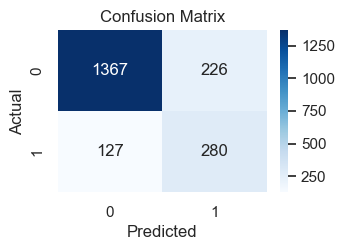

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      1593
           1       0.55      0.69      0.61       407

    accuracy                           0.82      2000
   macro avg       0.73      0.77      0.75      2000
weighted avg       0.84      0.82      0.83      2000



In [55]:
# Plot the confusion matrix as a heatmap

confusion = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(3, 2))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

### Improving the F1 Score

As the dataset is imbalanced, the target classes are unequally distributed. We can do this by two ways:
1. We can try using Synthetic Minority Oversampling Technique (SMOTE) to do data augmentation for the minority class. But that method is least preferred as it performs bad in generalized situations.
2. Downsampling the dataset to represent both classes of target equally.

Both approaches have been tried out below to show the impact of both techniques on F1 score and other metrics.

### 1. SMOTE

In [56]:
smote_pipe = bank_pipe = Pipeline([

    ## Unused columns ##
    ('unused_column_dropper', ColumnDropper(['customer_id'])),

    ## Binning age variable ##
    ('age_binner', Binner(['age'], [17, 40, 60, 100], ['A', 'B', 'C'])),

    ## Mapping ##
    ('all_mapper', Mapper({'products_number': {1:1, 2:2, 3:3, 4: 3}})),

    ## Outlier handling ##
    ('all_outlier', OutlierHandler(['credit_score'])),
    
    ## Binning age variable ##
    ('balance_binner', Binner(['balance'], [-1,50000, 100000, 150000, 200000, np.inf], ['A', 'B', 'C', 'D','E'])),

    ## Binning tenure variable ##
    ('tenure_binner', Binner(['tenure'], [-1, 2, 4, 6, 8, np.inf], ['A', 'B', 'C', 'D', 'E'])),
    
    ## One hot encoder ##
    ('one_hot_encoder', ColOneHotEncoder(['country', 'gender'])),

    ## Label encoder ##
    ('label_encoder', ColLabelEncoder(['age_binned', 'balance_binned', 'tenure_binned'])),
     
    ## scaler ##
    ('scaler', StandardScaler())
    
])

In [57]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled = smote_pipe.fit(X_train).transform(X_train)
X_test_resampled = smote_pipe.transform(X_test)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train)

In [58]:
model_smote = CatBoostClassifier(
    iterations=500, 
    depth=7, 
    learning_rate=0.1, 
    loss_function='Logloss',
    verbose=100
)

# Fit the model
model_smote.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = model_smote.predict(X_test_resampled)
print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print(f"AUC score: {roc_auc_score(y_test, y_pred): .2f}")
print(f"F1-score: {f1_score(y_test, y_pred):.2f}")

0:	learn: 0.6304807	total: 9.4ms	remaining: 4.69s
100:	learn: 0.2297484	total: 689ms	remaining: 2.72s
200:	learn: 0.1762047	total: 1.35s	remaining: 2.02s
300:	learn: 0.1463607	total: 2.04s	remaining: 1.34s
400:	learn: 0.1223128	total: 2.73s	remaining: 674ms
499:	learn: 0.1044728	total: 3.4s	remaining: 0us
Accuracy(in %): 85.05
AUC score:  0.74
F1-score: 0.60


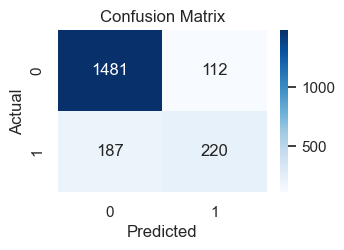

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.66      0.54      0.60       407

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000



In [59]:
# Plot the confusion matrix as a heatmap

confusion = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(3, 2))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

### 2. Downsampling dataset

In [60]:
df_0 = df[df['churn']==0]
df_0 = df_0.sample(frac=1).reset_index(drop=True) # For shuffling the rows
df_0 = df_0[:2000]

df_1 = df[df['churn']==1]
df_1 = df_1.sample(frac=1).reset_index(drop=True) # For shuffling the rows
df_1 = df_1[:2000]

df_down = pd.concat([df_0, df_1], axis=0, ignore_index=True)
df_down = df_down.sample(frac=1).reset_index(drop=True) # For shuffling the rows

df_down.shape

(4000, 12)

In [61]:
features = df_down.drop('churn', axis=1)
target = df_down['churn']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(features, target, test_size=0.20, random_state=42, stratify=target)
X_train_d.shape, y_train_d.shape, X_test_d.shape, y_test_d.shape

((3200, 11), (3200,), (800, 11), (800,))

In [62]:
down_pipe = Pipeline([

    ## Unused columns ##
    ('unused_column_dropper', ColumnDropper(['customer_id'])),

    ## Binning age variable ##
    ('age_binner', Binner(['age'], [17, 40, 60, 100], ['A', 'B', 'C'])),

    ## Mapping ##
    ('all_mapper', Mapper({'products_number': {1:1, 2:2, 3:3, 4: 3}})),

    ## Outlier handling ##
    ('all_outlier', OutlierHandler(['credit_score'])),
    
    ## Binning age variable ##
    ('balance_binner', Binner(['balance'], [-1,50000, 100000, 150000, 200000, np.inf], ['A', 'B', 'C', 'D','E'])),

    ## Binning tenure variable ##
    ('tenure_binner', Binner(['tenure'], [-1, 2, 4, 6, 8, np.inf], ['A', 'B', 'C', 'D', 'E'])),
    
    ## One hot encoder ##
    ('one_hot_encoder', ColOneHotEncoder(['country', 'gender'])),

    ## Label encoder ##
    ('label_encoder', ColLabelEncoder(['age_binned', 'balance_binned', 'tenure_binned'])),
     
    ## scaler ##
    ('scaler', StandardScaler()),

    ## Model fit
    ('model_cb', CatBoostClassifier(n_estimators=500, max_depth=7, learning_rate=0.05, loss_function='Logloss',
                                    random_state=42, verbose=0))
])

In [63]:
down_pipe.fit(X_train_d, y_train_d)
y_pred = down_pipe.predict(X_test_d)

In [64]:
print("Accuracy(in %):", accuracy_score(y_test_d, y_pred)*100)
print(f"AUC score: {roc_auc_score(y_test_d, y_pred): .2f}")
print(f"F1-score: {f1_score(y_test_d, y_pred):.2f}")

Accuracy(in %): 77.0
AUC score:  0.77
F1-score: 0.77


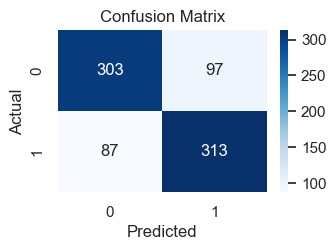

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77       400
           1       0.76      0.78      0.77       400

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.77       800
weighted avg       0.77      0.77      0.77       800



In [65]:
# Plot the confusion matrix as a heatmap

confusion = confusion_matrix(y_test_d,y_pred)

plt.figure(figsize=(3, 2))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test_d, y_pred)
print("Classification Report:\n", class_report)

Hence, instead of SMOTE, the approach of downsampling the dataset to have equal representation of target class gives better results in generalization and has the higher F1 score of 0.77.